# Mask R-CNN for Keypoint Detection

Notebook for inspecting the Mask R-CNN data loader and model output

In [1]:
USE_GPU    = True
MODEL_NAME = "run1"

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs", MODEL_NAME)

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Data for Keypoint Detection

In [2]:
from coco import coco_keypoints

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare datasets
dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True)
dataset_val.prepare()

Will use images in A:/Programming/DeepLearningDatasets/coco/val2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


### List the Keypoint Classes

In [3]:
print("Classes:")
print(dataset_val.class_names)
print()
print("Keypoint classes:")
print(dataset_val.kp_class_names)

Classes:
['BG', 'person']

Keypoint classes:
['MISSING', 'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


### Show an Example Image
Shows how to use ```visualize.display_keypoints``` to show keypoints on an image

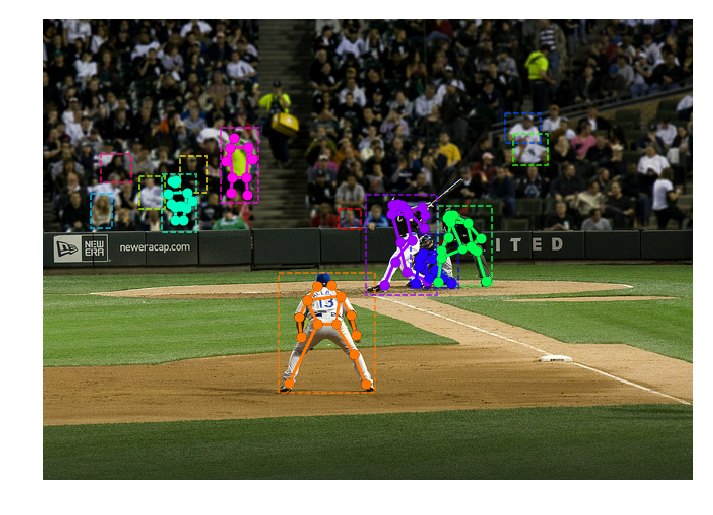

In [21]:
# Load an image from the validation set
image_id = dataset_val.image_ids[18]
#image_id = 869
#image_id = random.choice(dataset_val.image_ids)

image = dataset_val.load_image(image_id)

# Load masks and coresponding kp ids
masks, class_ids, kp_masks, kp_ids, bbox = dataset_val.load_mask(image_id, return_boxes=True)

# Show keypoints
import random
random.seed(0)
visualize.display_keypoints(image, bbox, kp_masks, kp_ids,
                            masks, show_masks=False,
                            skeleton=dataset_val.skeleton,
                            figsize=(12, 12))

## Inspect Model

In [6]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_val.num_classes
    NUM_KEYPOINTS = dataset_val.num_kp_classes
    RPN_NMS_THRESHOLD = 0.5
    
    # We increase this to try to eliminate degenerate predcitions
    DETECTION_MIN_CONFIDENCE = 0.8

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_SHAPE            [56, 56]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_kp_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

### Model Dataloader

Show how the networks ```modellib.load_image_gt``` sees the mask, bounding box and kp ids

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
gt_class_ids             shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:   75.00000  max:  795.00000  int32
gt_masks                 shape: (1024, 1024, 13)      min:    0.00000  max:    1.00000  bool
gt_kp_masks              shape: (13, 17)              min:    0.00000  max: 740860.00000  int32
gt_kp_ids                shape: (13, 17)              min:    0.00000  max:   17.00000  int32


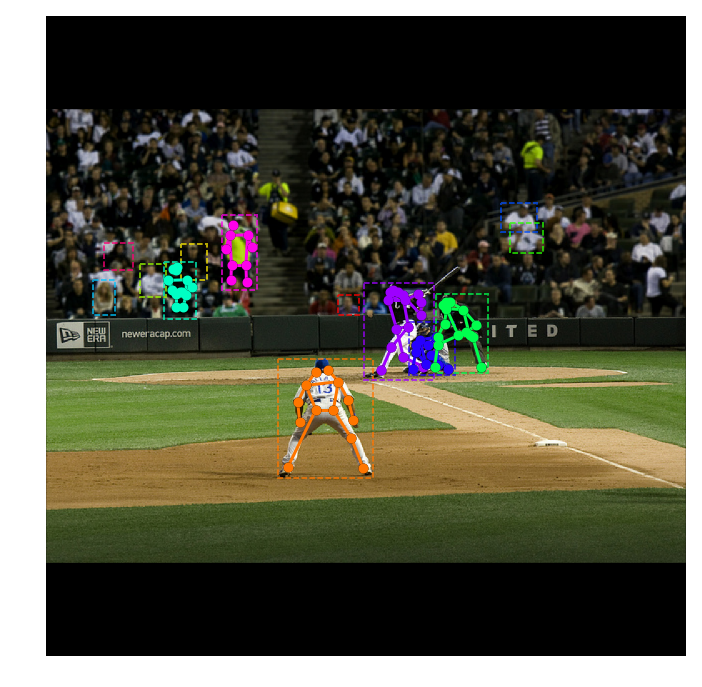

In [22]:
# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_bbox, gt_masks, gt_kp_ids, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, config, image_id)
    
# Display some tensor sizes
log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_masks)
log("gt_kp_masks", gt_kp_masks)
log("gt_kp_ids", gt_kp_ids)

# Show skeletons
import random
random.seed(0)
visualize.display_keypoints(image, gt_bbox,
                            utils.sparse_to_dense_masks(gt_kp_masks, image.shape), gt_kp_ids, gt_masks,
                            skeleton=dataset_val.skeleton,
                            #captions=dataset_val.kp_class_names,
                            show_masks=False,
                            figsize=(12, 12))

## Inference Output

In [7]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  A:\Programming\Pose_RCNN\logs\run1\coco_keypoints20180606T2342\mask_rcnn_coco_keypoints_0020.h5


image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
class_ids                shape: (17,)                 min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (13, 17)              min:    0.00000  max:   17.00000  int32
bbox                     shape: (17, 4)               min:   19.00000  max:  879.00000  int32
masks                    shape: (1024, 1024, 17)      min:    0.00000  max:    1.00000  bool


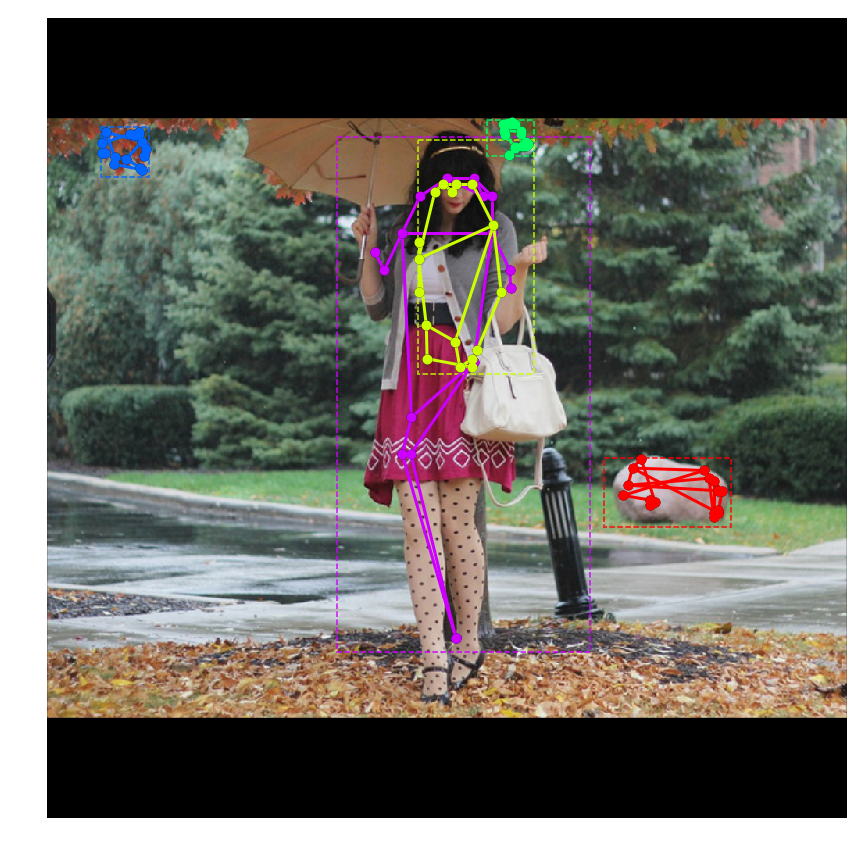

In [8]:
# Run the inference pipeline on the previous image
results = model.detect([image])
r = results[0]
bbox, masks, class_ids, scores, kp_masks = r["rois"], r["masks"], r["class_ids"], r["scores"], r["kp_masks"]

# Show output tensors
log("image", image)
log("class_ids", class_ids)
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", masks)

# Show skeletons
visualize.display_keypoints(image, bbox[0:5], kp_masks[0:5],
                            skeleton=dataset_train.skeleton,
                            figsize=(15, 15))

In [9]:
def unmold_detection(result, dataset, image_id, config):
    # Get scale and padding for image
    image_info = dataset.image_info[image_id]
    w, h = image_info["width"], image_info["height"]
    _, window, scale, padding, crop =\
        utils.resize_image(np.zeros((h, w, 3)),
                           min_dim=config.IMAGE_MIN_DIM,
                           max_dim=config.IMAGE_MAX_DIM,
                           min_scale=config.IMAGE_MIN_SCALE,
                           mode=config.IMAGE_RESIZE_MODE)
    pad_top, pad_bot, pad_left, pad_right = padding[0][0], padding[0][1], padding[1][0], padding[1][1]
    
    # Generate detections
    detections = []
    for instance_masks, score in zip(result["kp_masks"], result["scores"]):
        keypoints = []
        for kp_mask in instance_masks:
            kpy, kpx = np.unravel_index(np.argmax(kp_mask, axis=None), kp_mask.shape)
            kpx = (kpx - pad_left) / scale
            kpy = (kpy - pad_top) / scale
            keypoints.append(int(kpx))
            keypoints.append(int(kpy))
            keypoints.append(1)

        detections.append({
            "image_id": int(image_info["id"]),
            "category_id": 1,
            "keypoints": keypoints,
            "score": score
        })
    return detections

### Show Keypoint Heatmap

In [13]:
print(r["roi_kp_masks"].shape)

(1, 100, 17, 56, 56)


image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
class_ids                shape: (17,)                 min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int32
bbox                     shape: (17, 4)               min:   19.00000  max:  879.00000  int32
masks                    shape: (17, 17, 1024, 1024)  min:    0.00000  max:    0.99988  float32


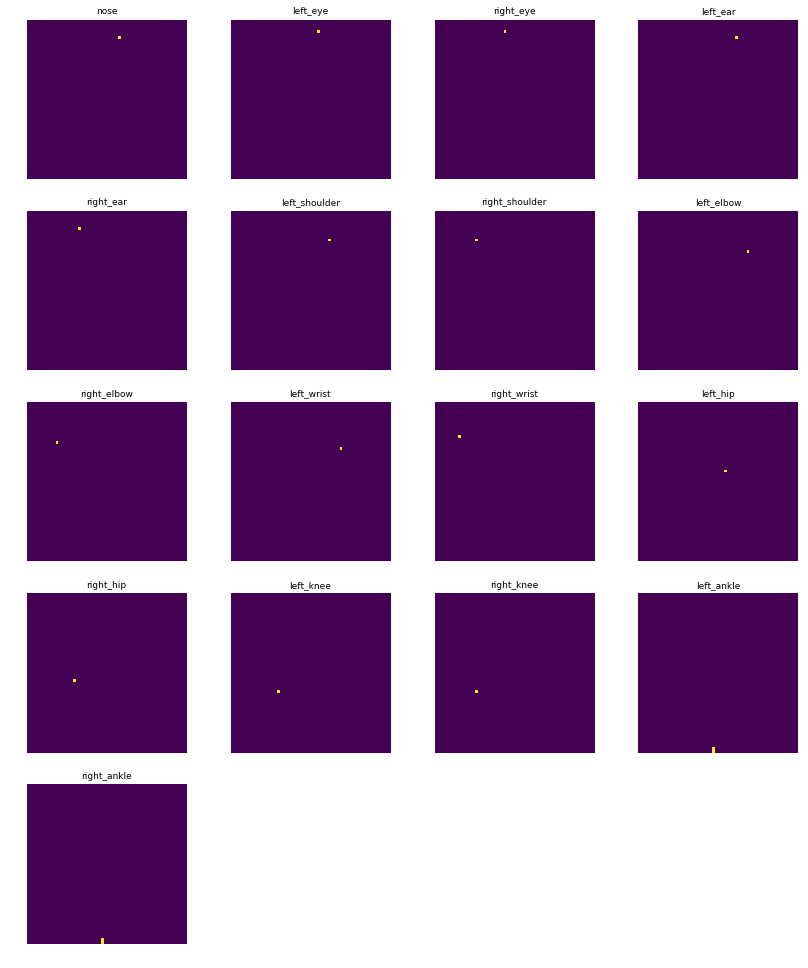

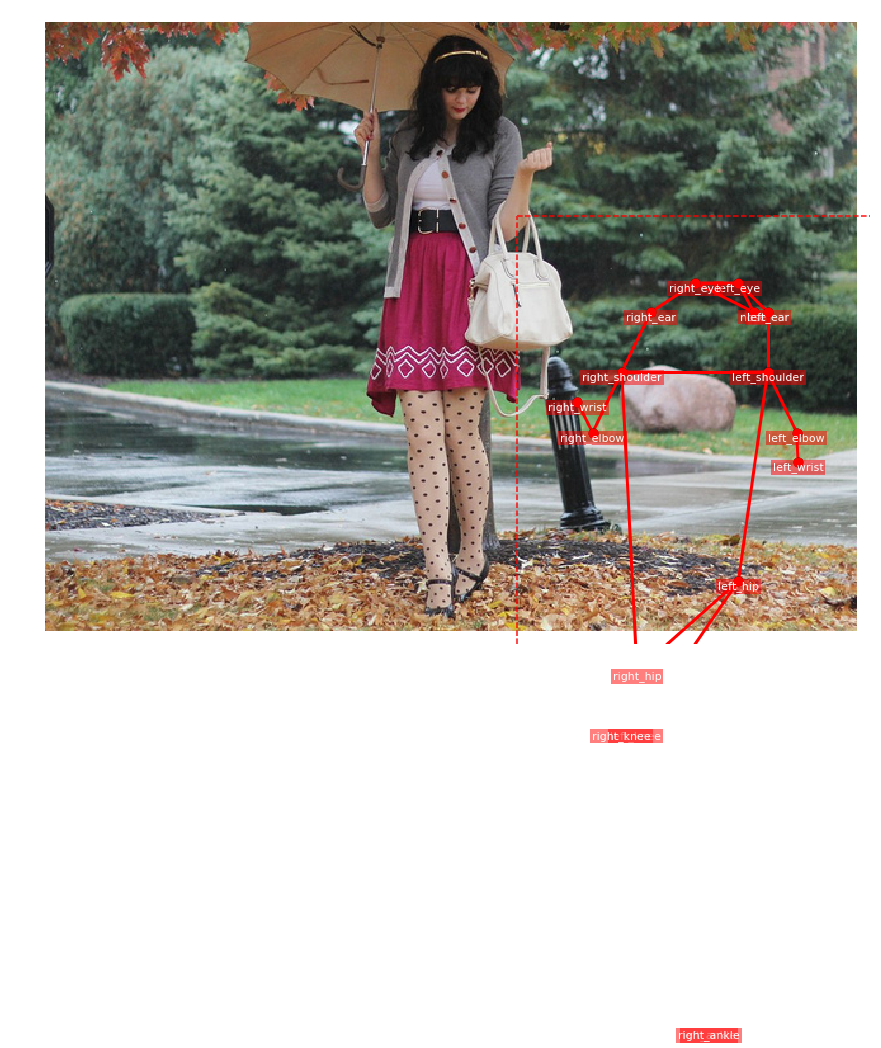

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

bbox, kp_masks, kp_ids = r["rois"], r["kp_masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

mask_index = 0

def plot_grid(images, titles=None):
    n = np.sqrt(len(images))
    _, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
    if n <= 1: axes = np.array(axes)
    for i, ax in enumerate(axes.flatten()):
        ax.axis("off")
        if i >= config.NUM_KEYPOINTS: continue    
        if titles is not None:
            ax.set_title(titles[i])
        ax.imshow(images[i])
    plt.show()

importlib.reload(visualize)

visualize.display_images(r["roi_kp_masks"][0][0], titles=dataset_val.kp_class_names[1:])
#lot_grid(kp_masks[mask_index], titles=dataset_val.kp_class_names[1:])

visualize.display_keypoints(image, bbox[mask_index:mask_index+1], kp_masks[mask_index:mask_index+1],
                            skeleton=dataset_train.skeleton,
                            captions=dataset_train.kp_class_names,
                            figsize=(15, 15))

### Show Grid of Random Images

In [ ]:
# Select 10 random images
for image_id in np.random.choice(dataset_val.image_ids, 10, replace=False):
    # Load an image from the validation set
    image = modellib.load_image_gt(dataset_val, config, image_id)[0]

    # Detect keypoints
    result = model.detect([image])[0]
    
    if result["rois"].shape[0] < 1:
        continue

    # Plot results
    visualize.display_keypoints(image, result["rois"][0:1], result["kp_masks"][0:1],
                                skeleton=dataset_train.skeleton,
                                title=str(image_id), figsize=(16, 16))

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


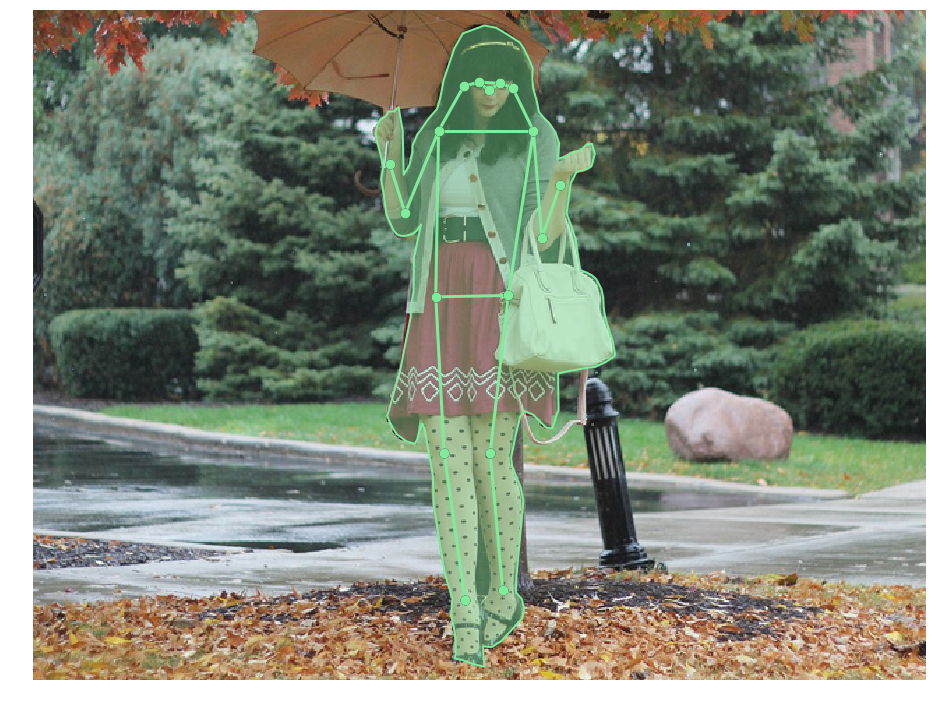

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


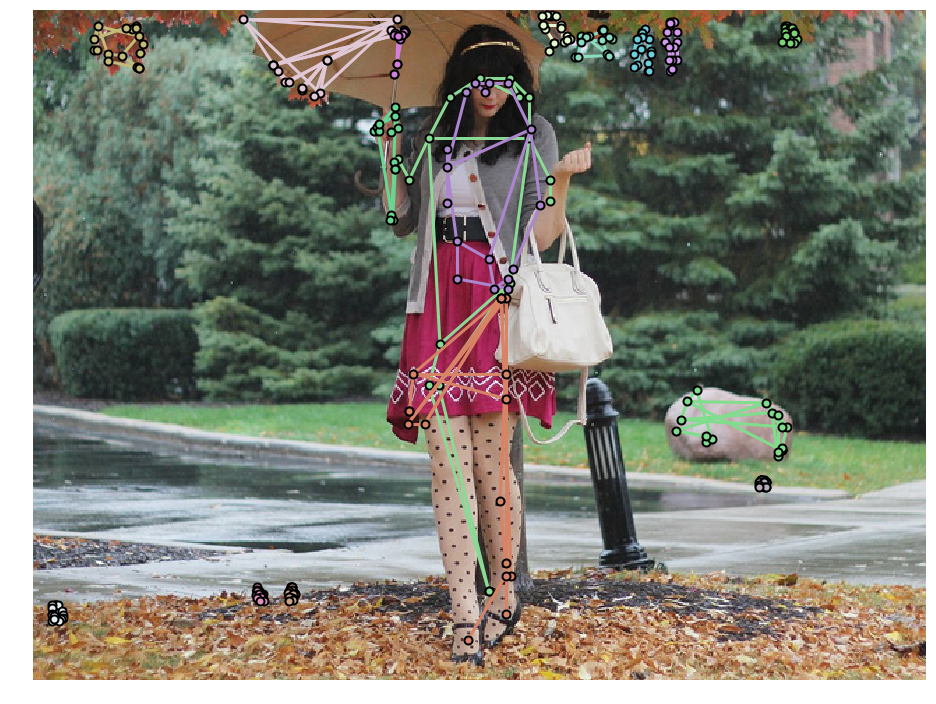

In [10]:
"""image = dataset_val.load_image(image_id)

from pycocotools.coco import COCO

annFile = '{}/annotations/person_keypoints_{}.json'.format(COCO_DATA_DIR,"val2017")
coco = COCO(annFile)

plt.figure(figsize=(16, 16))
plt.imshow(image); plt.axis('off')
coco.showAnns(coco.loadAnns(coco.getAnnIds(imgIds=dataset_val.image_info[image_id]["id"])))
plt.show()

coco_dt = coco.loadRes(unmold_detection(r, dataset_val, image_id, config))

plt.figure(figsize=(16, 16))
plt.imshow(image); plt.axis('off')
coco_dt.showAnns(coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=dataset_val.image_info[image_id]["id"])))
plt.show()
"""